In [288]:
import numpy as np
import pandas as pd
import math
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes 
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib import rc
import seaborn as sns
import pandas as pd
from scipy import stats
from scipy.optimize import curve_fit
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
from mpl_toolkits.mplot3d import Axes3D
import ternary
import warnings
import random
from alive_progress import alive_bar
import time

%matplotlib inline
warnings.filterwarnings('ignore')

## Here, I restricted parameter values to % of ranges found in Fung et al., 2011 to yield alternative stable states in the CAm

***Parameter space subregion type IV:*** All parameters restricted to 15% within pristine range ends.

$r = [0.02–0.032], [0.088–0.1] yr^{-1}$  *(Fung et al., 2011)*

$γ = [0.05-0.1025],  [0.3475-0.4] yr^{-1}$ *Fung et al., 2011*

$β = [2-4.7], [17.3-20] yr^{-1}$ *(Fung et al., 2011)*

$α1 = [0-0.15], [0.85-1]$ *(Fung et al., 2011)*

$α2 = [0-0.135], [0.765-0.9]$ *(Fung et al., 2011)*

$α3 = [0-0.135], [0.765-0.9]$ *(Fung et al., 2011)*

$μ =  [0.04–0.064],  [0.176–0.2] yr^{-1}$  *(Fung et al., 2011)*

$pM =  [0.05-0.065], [0.135 - 0.15]$ yr^{-1} this takes the values for grazing used in Fung

$pT [5-6.5], [13.5 - 15]$ yr^{-1} this takes the values for grazing used in Fung

# Defining ODE & parameter ranges

In [2]:
def dNdt(t, N, r, γ, β, α1, α2, α3, μ, pM, pT):
    
    C,M,T = N
    
    dC = (r*C*(1-C-M-T) + α1*r*C*T - α3*γ*C*M - μ*C)*dt
    dM = (γ*M*(1-C-M-T) + α2*γ*T*M + α3*γ*C*M - pM*M)*dt
    dT = (β*T*(1-C-M-T) - α1*r*C*T - α2*γ*T*M - pT*T)*dt

    return dC, dM, dT

# Type IV Parameter Space Subregion
### Searching for different ecosystem states

In [3]:
r_low15 = np.linspace(0.04, 0.064, 10)
r_top15 = np.linspace(0.176, 0.2, 10)

γ_low15 = np.linspace(0.05, 0.1025, 10)
γ_top15 = np.linspace(0.3475, 0.4, 10)

β_low15 = np.linspace(2, 4.7, 10)
β_top15 = np.linspace(17.3, 20, 10)

α1_low15 = np.linspace(0, 0.15, 10)
α1_top15 = np.linspace(0.85, 1, 10)

α2_low15 = np.linspace(0, 0.135, 10)
α2_low15 = np.linspace(0.765, 0.9, 10)

α3_low15 = np.linspace(0, 0.135, 10)
α3_low15 = np.linspace(0.765, 0.9, 10)

μ_low15 = np.linspace(0.02, 0.032, 10)
μ_top15 = np.linspace(0.088, 0.1, 10)

pM_low15 = np.linspace(0.05, 0.065, 10)
pM_top15 = np.linspace(0.135, 0.15, 10)

pT_low15 = np.linspace(5, 6.5, 10)
pT_top15 = np.linspace(13.5, 15, 10)

In [100]:
dt = 1
NUMSTEPS = 3000
NUMYEARS = int(NUMSTEPS/dt)
time_points = np.linspace(0, NUMYEARS, NUMSTEPS+1)

C0 = 0.99
M0 = 0.005
T0 = 0.005

reps = range(100)

def AltSS(): 
    
    outputs = []
    outputs_prime = []

    for i in reps:

        r = np.random.uniform(r_top15)[0]
        γ = np.random.uniform(γ_low15)[0]
        β = np.random.uniform(β_low15)[0]
        α1 = np.random.uniform(α1_top15)[0]
        α2 = np.random.uniform(α2_low15)[0]
        α3 = np.random.uniform(α3_low15)[0]
        μ = np.random.uniform(μ_low15)[0]
        pM = np.random.uniform(pM_top15)[0]
        pT = np.random.uniform(pT_top15)[0]

        sol = solve_ivp(dNdt, [0,NUMYEARS], [C0, M0, T0], method = 'RK45', args = 
                        (r, γ, β, α1, α2, α3, μ, pM, pT), dense_output=True)

        N = sol.sol(time_points) 

        C_array = N[0,:]
        M_array = N[1,:]
        T_array = N[2,:]

        outputs.append((r, γ, β, α1, α2, α3, μ, pM, pT, C_array, M_array, T_array))
        outputs_prime.append((r, γ, β, α1, α2, α3, μ, pM, pT, C_array[-1], M_array[-1], T_array[-1]))

    df_timeseries = pd.DataFrame(outputs, columns=['r', 'γ', 'β', 'α1', 'α2', 'α3', 'μ', 'pM', 'pT', 'C_array','M_array','T_array'])
    df_prime = pd.DataFrame(outputs_prime, columns=['r', 'γ', 'β', 'α1', 'α2', 'α3', 'μ', 'pM', 'pT','C_prime','M_prime','T_prime'])
    return(df_timeseries, df_prime)

In [145]:
def plottime(df, name):
    
    df = df[0]
    
    C_array = df['C_array']
    M_array = df['M_array']
    T_array = df['T_array']

    figure, ax = plt.subplots(ncols=3, nrows = 1, sharey=True, figsize=(40, 10))

    for i in range(100):
        ax[0].plot(C_array[i], c = 'purple')
        ax[1].plot(M_array[i], c = 'green')
        ax[2].plot(T_array[i], c = 'orange')
        
        ax[0].set_xlim(0, NUMYEARS)
        ax[1].set_xlim(0, NUMYEARS)
        ax[2].set_xlim(0, NUMYEARS)
    
        ax[0].set_title('C prime, '+str(name), fontsize = 30)
        ax[1].set_title('M prime, '+str(name), fontsize = 30)
        ax[2].set_title('T prime, '+str(name), fontsize = 30);

In [102]:
start_time = time.perf_counter()

df = AltSS()

end_time = time.perf_counter()
(end_time - start_time)/60

4.399251465000756

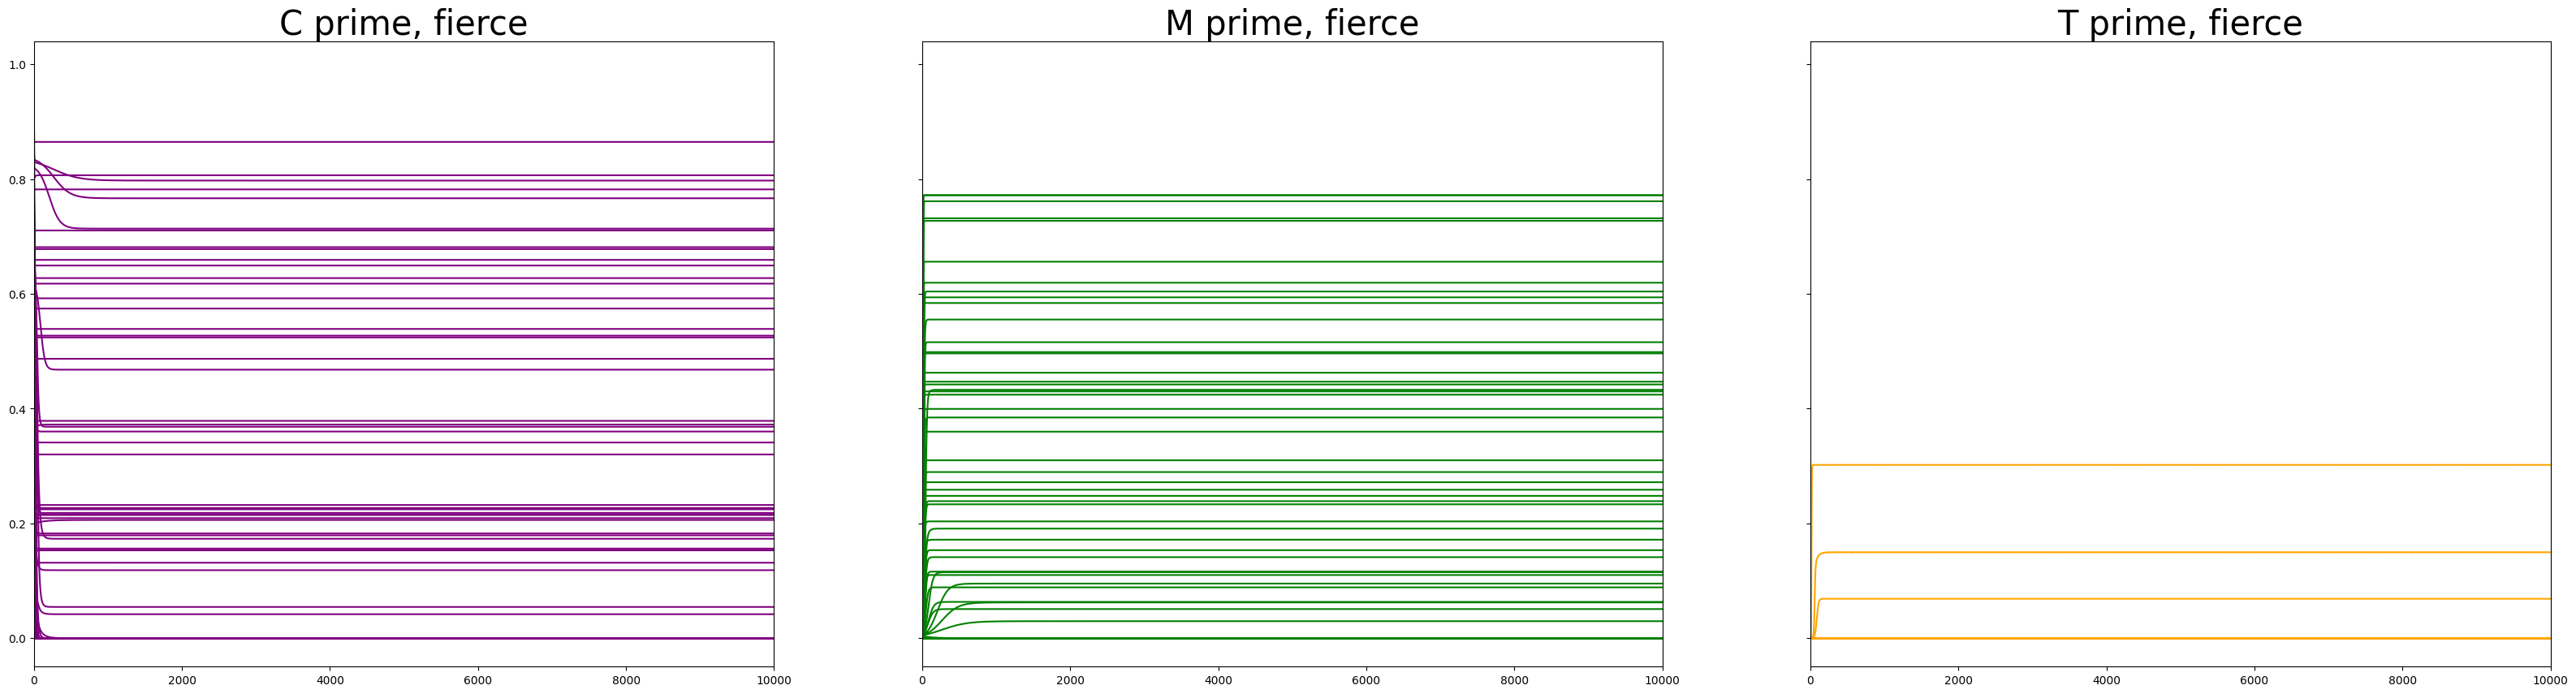

In [103]:
plottime(df, "fierce")

In [198]:
dt = 1
NUMSTEPS = 10000
NUMYEARS = int(NUMSTEPS/dt)
time_points = np.linspace(0, NUMYEARS, NUMSTEPS+1)

C0 = 0.99
M0 = 0.005
T0 = 0.005

pM_val = np.linspace(0.05, 0.15, 10)
#reps = range(100)

In [4]:

def AltSS(): 
    
    outputs = []
    outputs_prime = []

    #for i in reps:
        
    for pM in pM_val:
        r = 0.2
        γ = 0.35
        β = 5
        α1 = 0.25
        α2 = 0.9
        α3 = 0.1
        μ = 0.05
        pM = pM
        pT = 10

        sol = solve_ivp(dNdt, [0,NUMYEARS], [C0, M0, T0], method = 'RK45', args = 
                        (r, γ, β, α1, α2, α3, μ, pM, pT), dense_output=True)

        N = sol.sol(time_points) 

        C_array = N[0,:]
        M_array = N[1,:]
        T_array = N[2,:]

        outputs.append((r, γ, β, α1, α2, α3, μ, pM, pT, C_array, M_array, T_array))
        outputs_prime.append((r, γ, β, α1, α2, α3, μ, pM, pT, C_array[-1], M_array[-1], T_array[-1]))

    df_timeseries = pd.DataFrame(outputs, columns=['r', 'γ', 'β', 'α1', 'α2', 'α3', 'μ', 'pM', 'pT', 'C_array','M_array','T_array'])
    df_prime = pd.DataFrame(outputs_prime, columns=['r', 'γ', 'β', 'α1', 'α2', 'α3', 'μ', 'pM', 'pT','C_prime','M_prime','T_prime'])
    return(df_timeseries, df_prime)

In [316]:
def plottime(df, name):
    
    df = df[1]
    
    C_prime = df['C_prime']
    M_prime = df['M_prime']
    T_prime = df['T_prime']
    pM = df['pM']

    #for i in range(10):
    plt.scatter(pM, C_prime, c = 'purple')
    plt.scatter(pM, M_prime, c = 'green')
    plt.scatter(pM, T_prime, c = 'orange')
        
        #plt.xlim(0, NUMYEARS)
    
        #ax[0].set_title('C prime, '+str(name), fontsize = 30)
        #ax[1].set_title('M prime, '+str(name), fontsize = 30)
    plt. title(''+str(name), fontsize = 30);

In [6]:
start_time = time.perf_counter()

df_1 = AltSS()

end_time = time.perf_counter()
(end_time - start_time)/60

0.393268990000009

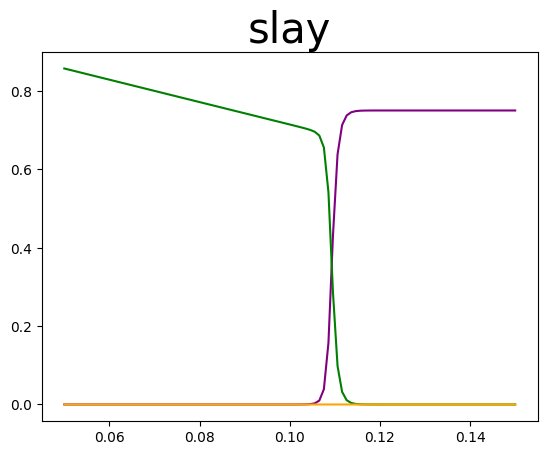

In [7]:
plottime(df_1, "slay")

In [212]:
np.linspace(0,1,11)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [167]:
pM_val

array([0.05      , 0.06111111, 0.07222222, 0.08333333, 0.09444444,
       0.10555556, 0.11666667, 0.12777778, 0.13888889, 0.15      ])

In [213]:
def AltSS_2(): 
    
    outputs = []
    outputs_prime = []
    
    for pM in pM_val:

        #for i in range(1000):

        for C0 in np.linspace(0,1,11):
            
            for M0 in np.linspace(0,1,11):
            
                for T0 in np.linspace(0,1,11):
            
                    r = 0.2
                    γ = 0.35
                    β = 5
                    α1 = 0.25
                    α2 = 0.9
                    α3 = 0.1
                    μ = 0.05
                    pM = pM
                    pT = 10

                    if (C0 + M0 + T0 <= 1):

                        sol = solve_ivp(dNdt, [0,NUMYEARS], [C0, M0, T0], method = 'RK45', args = 
                                    (r, γ, β, α1, α2, α3, μ, pM, pT), dense_output=True)

                        N = sol.sol(time_points) 

                        C_array = N[0,:]
                        M_array = N[1,:]
                        T_array = N[2,:]

                        outputs.append((r, γ, β, α1, α2, α3, μ, pM, pT, C_array, M_array, T_array))
                        outputs_prime.append((r, γ, β, α1, α2, α3, μ, pM, pT, C_array[-1], M_array[-1], T_array[-1]))

    df_timeseries = pd.DataFrame(outputs, columns=['r', 'γ', 'β', 'α1', 'α2', 'α3', 'μ', 'pM', 'pT', 'C_array','M_array','T_array'])
    df_prime = pd.DataFrame(outputs_prime, columns=['r', 'γ', 'β', 'α1', 'α2', 'α3', 'μ', 'pM', 'pT','C_prime','M_prime','T_prime'])
    return(df_timeseries, df_prime)


In [217]:
start_time = time.perf_counter()

df_3 = AltSS_2()

end_time = time.perf_counter()
(end_time - start_time)/60

116.98776038166665

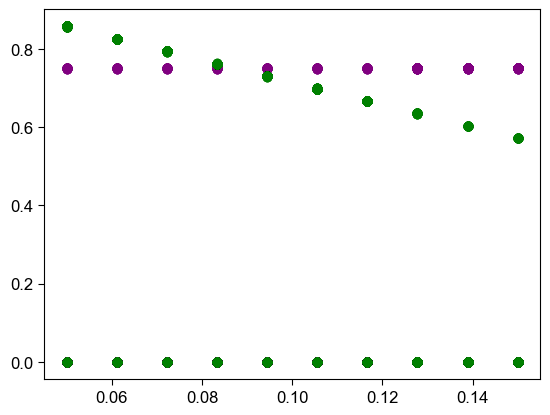

In [437]:


#unique_T = df_3[1].drop_duplicates(subset=['T_prime'])
#unique_T


plt.scatter(df_3[1]['pM'], df_3[1]['C_prime'], c = 'purple')
plt.scatter(df_3[1]['pM'], df_3[1]['M_prime'], c = 'green')
#plt.scatter(unique_T['pM'], unique_T['T_prime'], c = 'orange')'

In [401]:
df_05['C_array'][1000][0]>0

True

In [297]:
def plotPhPl(df, pM):
    
    df_PhPl = df[0][df[0]['pM'] == pM]
    df_PhPl = df_PhPl.reset_index(drop=True)
    pM = round(pM, 3)
    x = len(df_PhPl)
    
    for i in range(x):

        C_array = df_PhPl['C_array'][i]
        M_array = df_PhPl['M_array'][i]
        T_array = df_PhPl['T_array'][i]

        if (C_array[-1] > M_array[-1]): #mostly-C (McManus et al., 2019)
            color = 'purple'
            linestyle = 'dotted'
            linewidth = 2
            alpha = 0.5

        if (M_array[-1] > C_array[-1]): #mostly-M (McManus et al., 2019)
            color = 'green'
            linestyle = 'dotted'
            linewidth = 2
            alpha = 0.5

        if (C_array[-1] > 0.01 and M_array[-1] < 0.01): #all-C (McManus et al., 2019)
            color = 'indigo'
            linestyle = 'solid'
            linewidth = 1
            alpha = 1

        if (M_array[-1] > 0.01 and C_array[-1] < 0.01): #all-M (McManus et al., 2019)
            color = 'darkgreen'
            linestyle = 'solid'
            linewidth = 1
            alpha = 1

        if (M_array[-1] < 0.01 and C_array[-1] < 0.01): #all-T (McManus et al., 2019)
            color = 'orange'
            linestyle = 'solid'
            linewidth = 1
            alpha = 1
            
        ## add another one of these clauses for free space???

        plt.plot(C_array, M_array, color=color, linestyle=linestyle, linewidth=linewidth, alpha=alpha) # plot the trajectory in the phase plane (plot A)
        item1 = plt.scatter(C_array[0], M_array[0], color='blue', s=20, alpha=0.6) # plot the starting point in blue
        item2 = plt.scatter(C_array[-1], M_array[-1], color='red', s=50) # plot the final point in red


    plt.legend([item1, item2], ['time step=0', 'time step=10,000'], fontsize=10)
    plt.xlabel("Coral Cover", fontsize=10);
    plt.ylabel("Macroalgae Cover", fontsize=10);
    plt.title('Coral-Algal Phase Plane (pM = ' +str(pM)+')', fontsize=14);

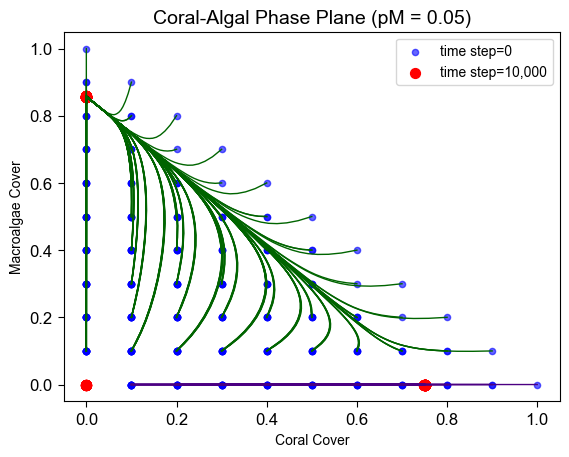

In [298]:
plotPhPl(df_3, 0.05)

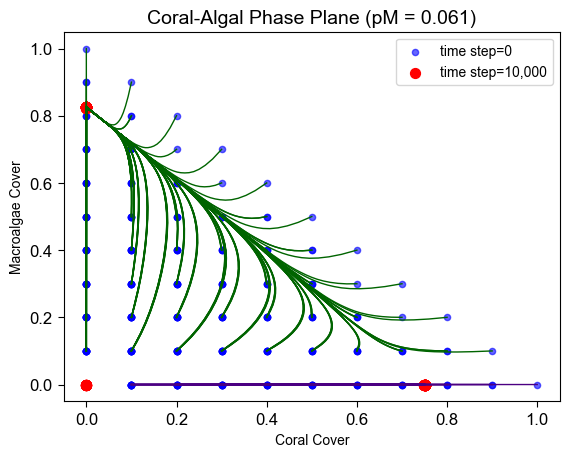

In [308]:
plotPhPl(df_3, 0.061111111111111116)

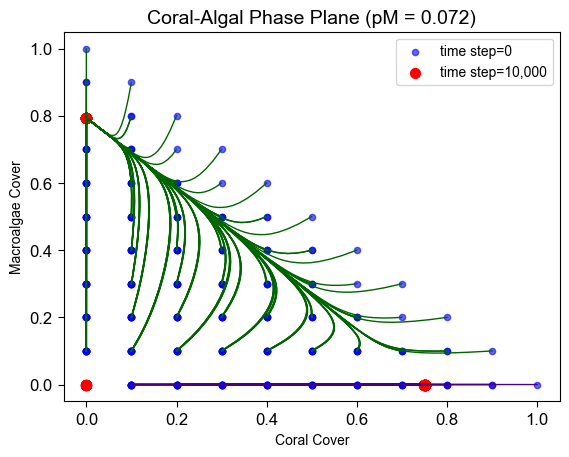

In [310]:
plotPhPl(df_3, 0.07222222222222222)

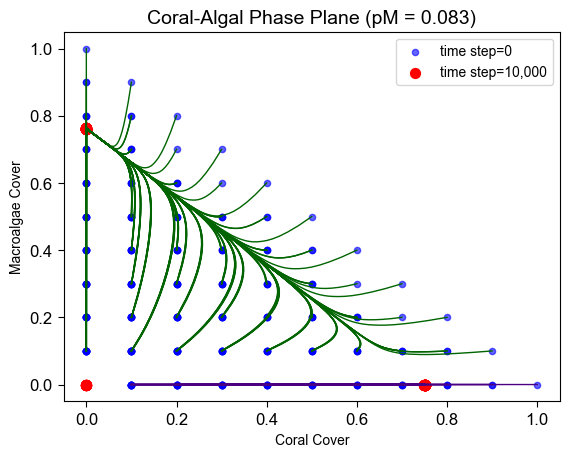

In [299]:
plotPhPl(df_3, 0.08333333333333333)

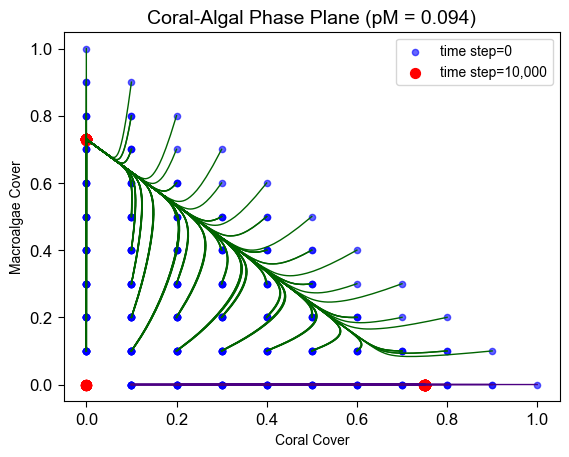

In [315]:
plotPhPl(df_3, 0.09444444444444444)

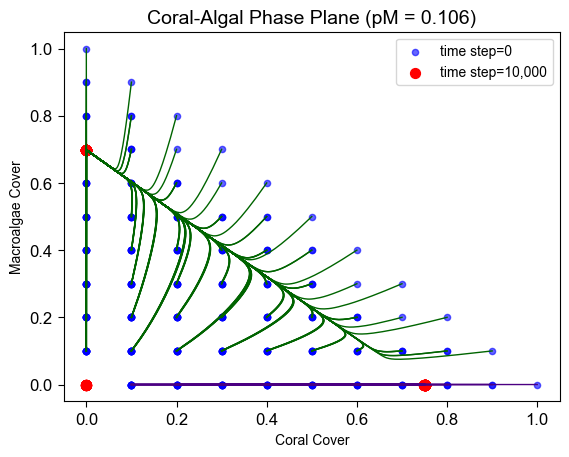

In [320]:
plotPhPl(df_3, 0.10555555555555556)

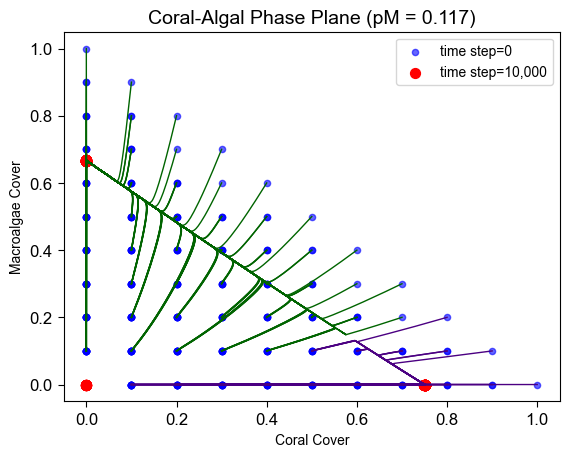

In [324]:
plotPhPl(df_3, 0.11666666666666665)

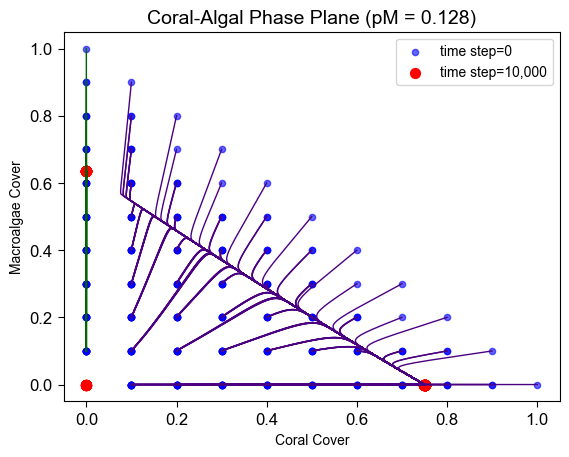

In [302]:
plotPhPl(df_3, 0.12777777777777777)

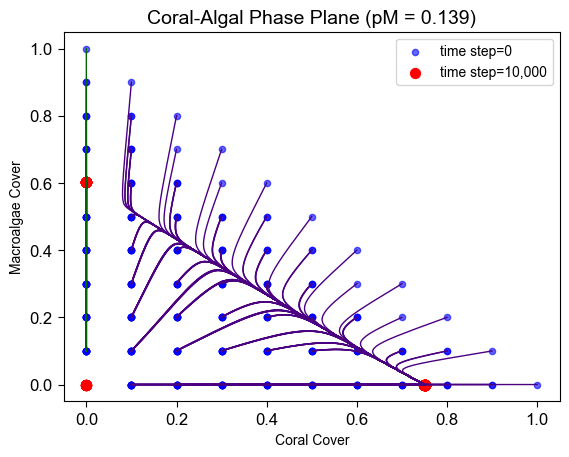

In [330]:
plotPhPl(df_3, 0.1388888888888889)

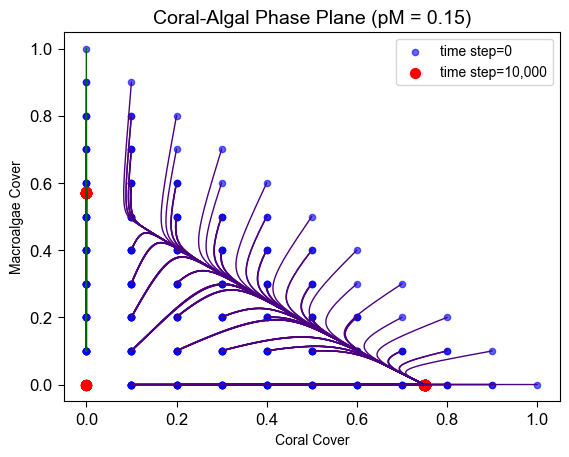

In [334]:
plotPhPl(df_3, 0.15)

***Parameter space subregion type V:*** pM restricted to lowest 45% of pristine range. γ and alpha3 restricted to top 45% of pristine ranges.

$r = [0.02–0.1] yr^{-1}$  *(Fung et al., 2011)*

$γ = [0.2425 - 0.4] yr^{-1}$ *Fung et al., 2011*

$β = [2-20] yr^{-1}$ *(Fung et al., 2011)*

$α1 = [0-1]$ *(Fung et al., 2011)*

$α2 = [0-0.9]$ *(Fung et al., 2011)*

$α3 = [0.495 - 0.9]$ *(Fung et al., 2011)*

$μ =  [0.04–0.2] yr^{-1}$  *(Fung et al., 2011)*

$pM =  [0.05-0.095]$ yr^{-1} this takes the values for grazing used in Fung

$pT [5-15]$ yr^{-1} this takes the values for grazing used in Fung


# Defining PMEQ function
This function selects random values for each parameter from pristine parameter ranges defined in Fung et al., 2011* according to independent uniform distributions, while allowing me to adjust the value for macroalgae mortality (pM).

*I calculated the range of pM with a formulation from Cook et al., 2023. The range of pT is arbitrary. All other parameter ranges come from Fung et al., 2011.

In [299]:
dt = 1
NUMSTEPS = 10000
NUMYEARS = int(NUMSTEPS/dt)
time_points = np.linspace(0, NUMYEARS, NUMSTEPS+1)

C0 = 0.99
M0 = 0.005
T0 = 0.005

def PMEQ(x):
    
    outputs = []
    outputs_prime = []

    for i in range(100):

        r = np.random.uniform(0.04, 0.2, 1)[0]
        gamma = np.random.uniform(0.05, 0.4, 1)[0]
        beta = np.random.uniform(2, 20, 1)[0]
        alpha1 = np.random.uniform(0, 1, 1)[0]
        alpha2 = np.random.uniform(0, 0.9, 1)[0]
        alpha3 = np.random.uniform(0, 0.9, 1)[0]
        mu = np.random.uniform(0.02, 0.1, 1)[0]
        pM = x
        pT = np.random.uniform(0, 1, 1)[0]

        sol = solve_ivp(dNdt, [0,NUMYEARS], [C0, M0, T0], method = 'RK45', args = 
                            (r, gamma, beta, alpha1, alpha2, alpha3, mu, pM, pT), dense_output=True)

        N = sol.sol(time_points) 

        C_array = N[0,:]
        M_array = N[1,:]
        T_array = N[2,:]

        outputs.append((r, gamma, beta, alpha1, alpha2, alpha3, mu, pM, pT, C_array, M_array, T_array))
        outputs_prime.append((r, gamma, beta, alpha1, alpha2, alpha3, mu, pM, pT, C_array[-1], M_array[-1], T_array[-1]))

    df_timeseries = pd.DataFrame(outputs, columns=['r', 'gamma', 'beta', 'alpha1', 'alpha2', 'alpha3', 'mu', 'pM', 'pT', 'C_array','M_array','T_array'])
    df_prime = pd.DataFrame(outputs_prime, columns=['r', 'gamma', 'beta', 'alpha1', 'alpha2', 'alpha3', 'mu', 'pM', 'pT','C_prime','M_prime','T_prime'])
    return(df_timeseries, df_prime)

# Defining function to plot time series of each run
### This was done to ensure each parameter combination reached equilibrium.

In [300]:
def plottime(df, name):
    
    df = df[0]
    
    C_array = df['C_array']
    M_array = df['M_array']
    T_array = df['T_array']

    figure, ax = plt.subplots(ncols=3, nrows = 1, sharey=True, figsize=(40, 10))

    for i in range(100):
        ax[0].plot(C_array[i], c = 'purple')
        ax[1].plot(M_array[i], c = 'green')
        ax[2].plot(T_array[i], c = 'orange')
        
        ax[0].set_xlim(0, NUMYEARS)
        ax[1].set_xlim(0, NUMYEARS)
        ax[2].set_xlim(0, NUMYEARS)
    
        ax[0].set_title('C prime, '+str(name), fontsize = 30)
        ax[1].set_title('M prime, '+str(name), fontsize = 30)
        ax[2].set_title('T prime, '+str(name), fontsize = 30);

# Running PMEQ function and plotting time series

### pM = 0.02

In [301]:
start_time = time.perf_counter()

df_pM02 = PMEQ(0.02)

end_time = time.perf_counter()
(end_time - start_time)/60

2.349946446667309

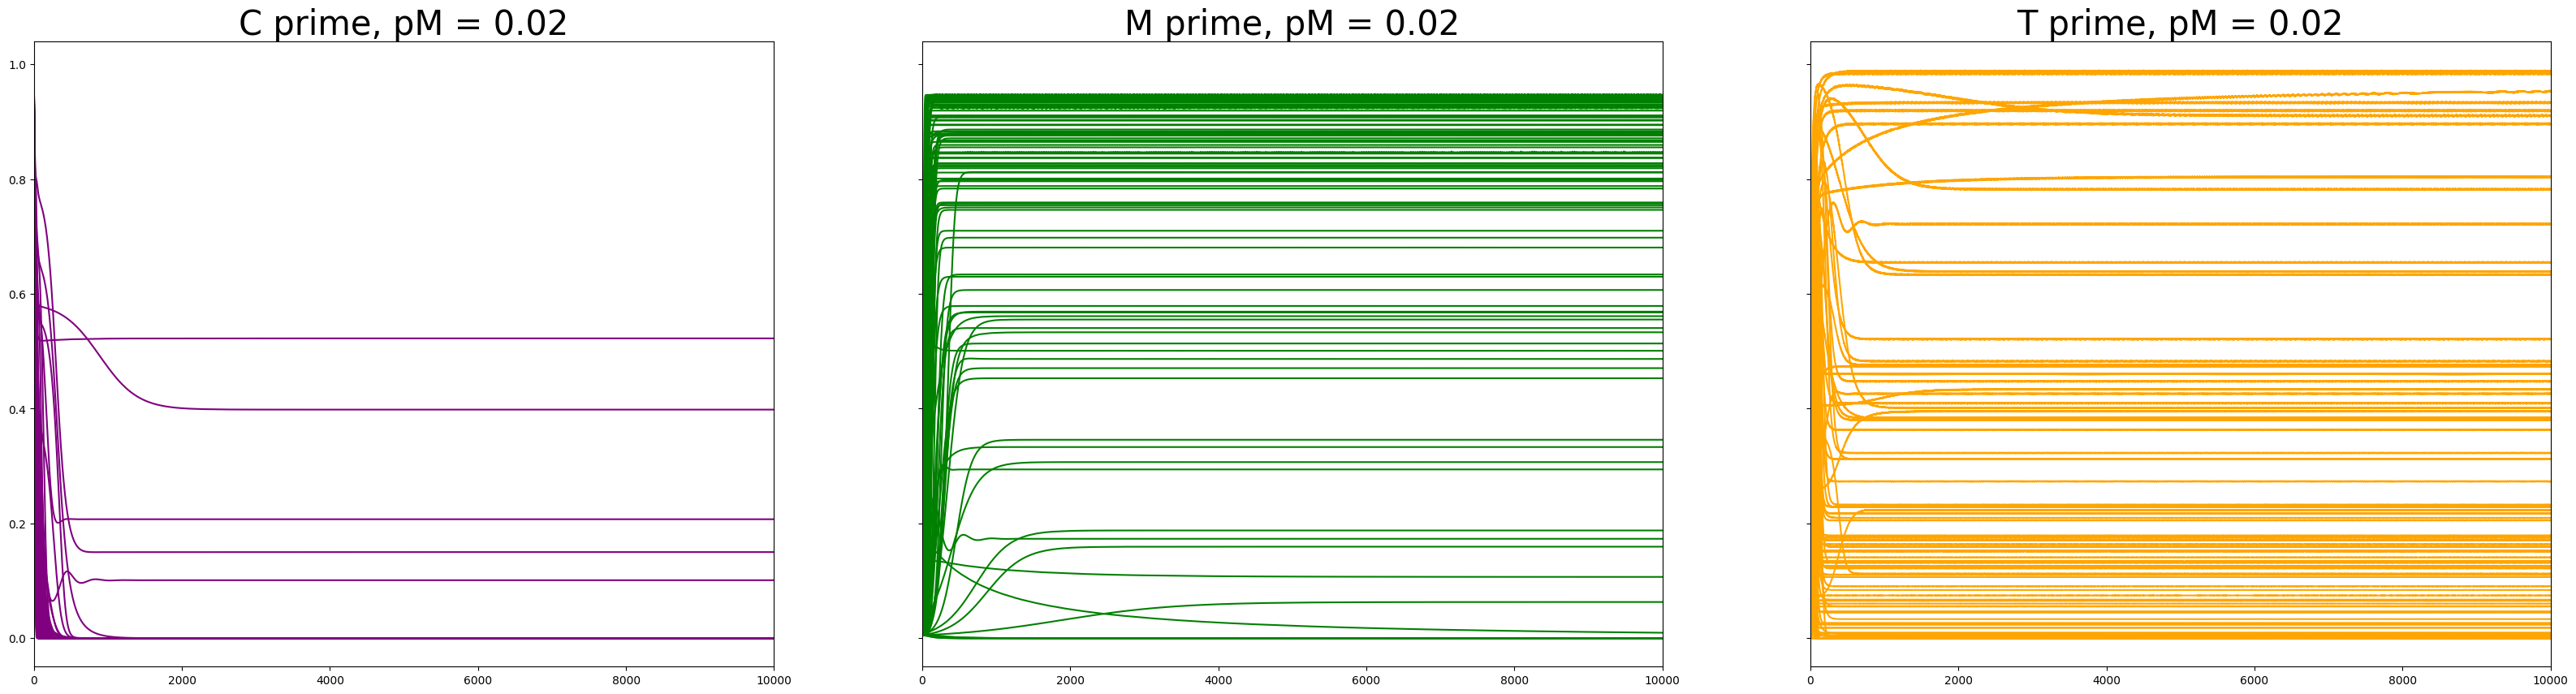

In [372]:
plottime(df_pM02, "pM = 0.02")

### pM = 0.14

In [303]:
start_time = time.perf_counter()

df_pM14 = PMEQ(0.14)

end_time = time.perf_counter()
(end_time - start_time)/60

5.831806491666551

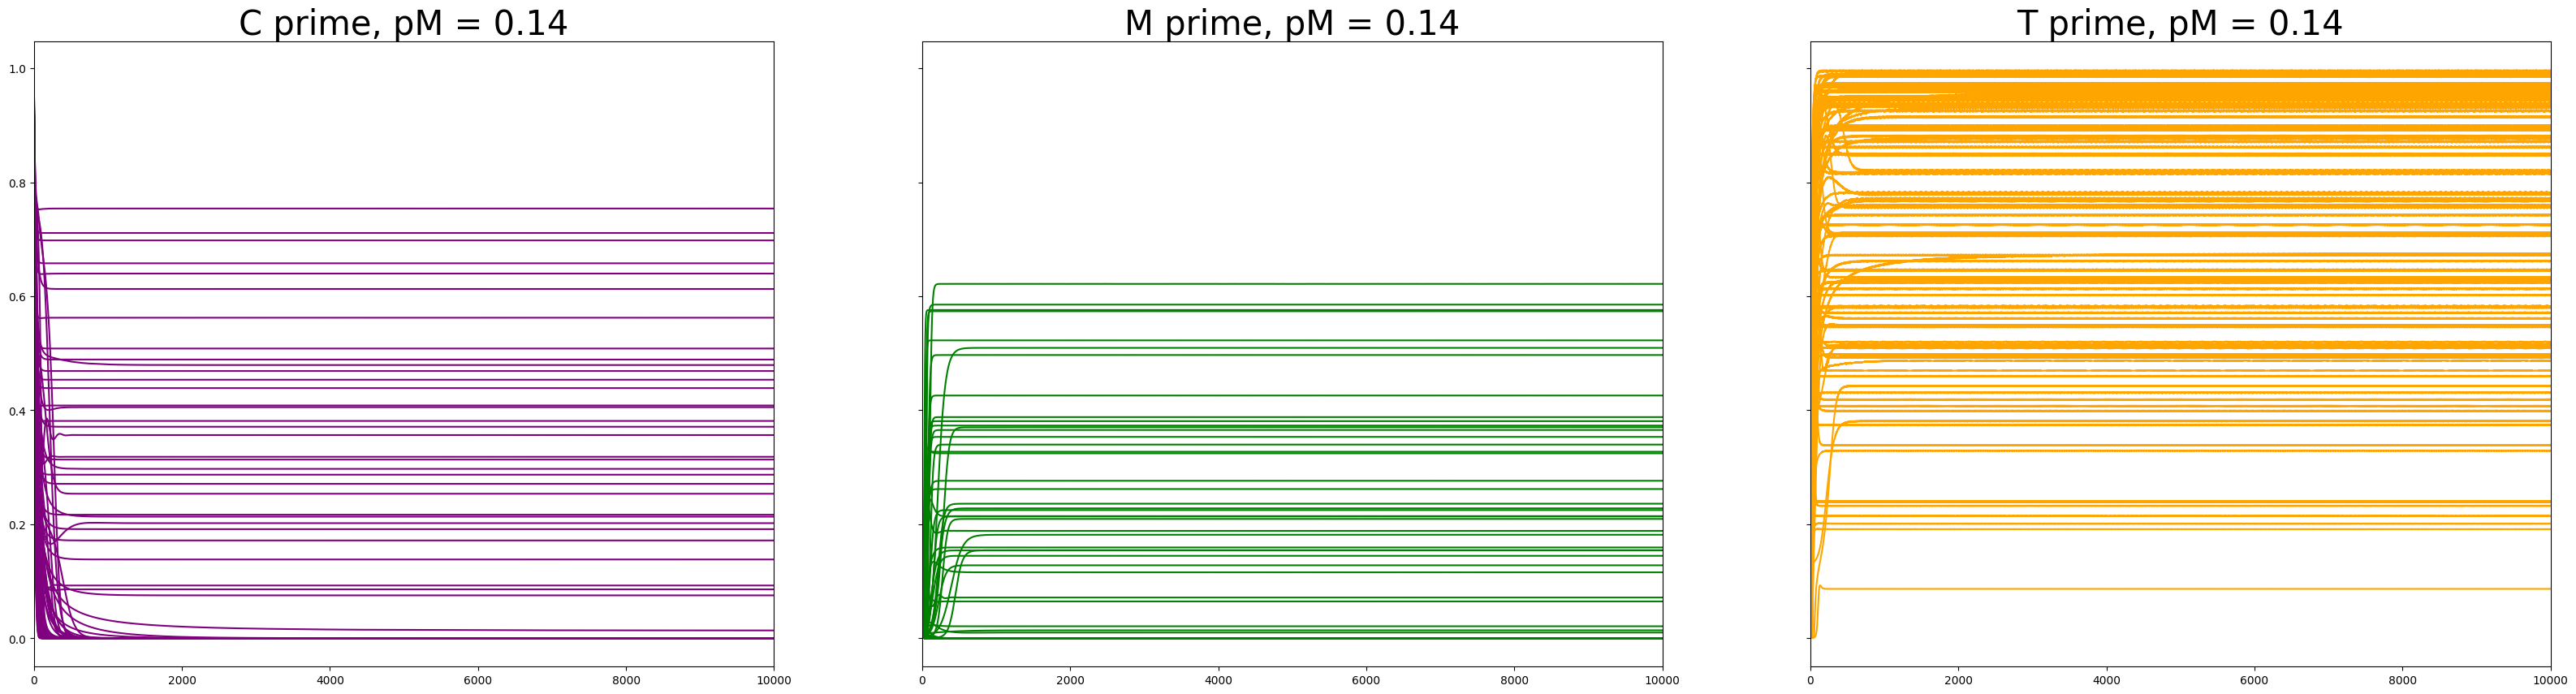

In [304]:
plottime(df_pM14, "pM = 0.14")

### pM = 0.26

In [358]:
start_time = time.perf_counter()

df_pM26 = PMEQ(0.26)

end_time = time.perf_counter()
(end_time - start_time)/60

5.659519911666091

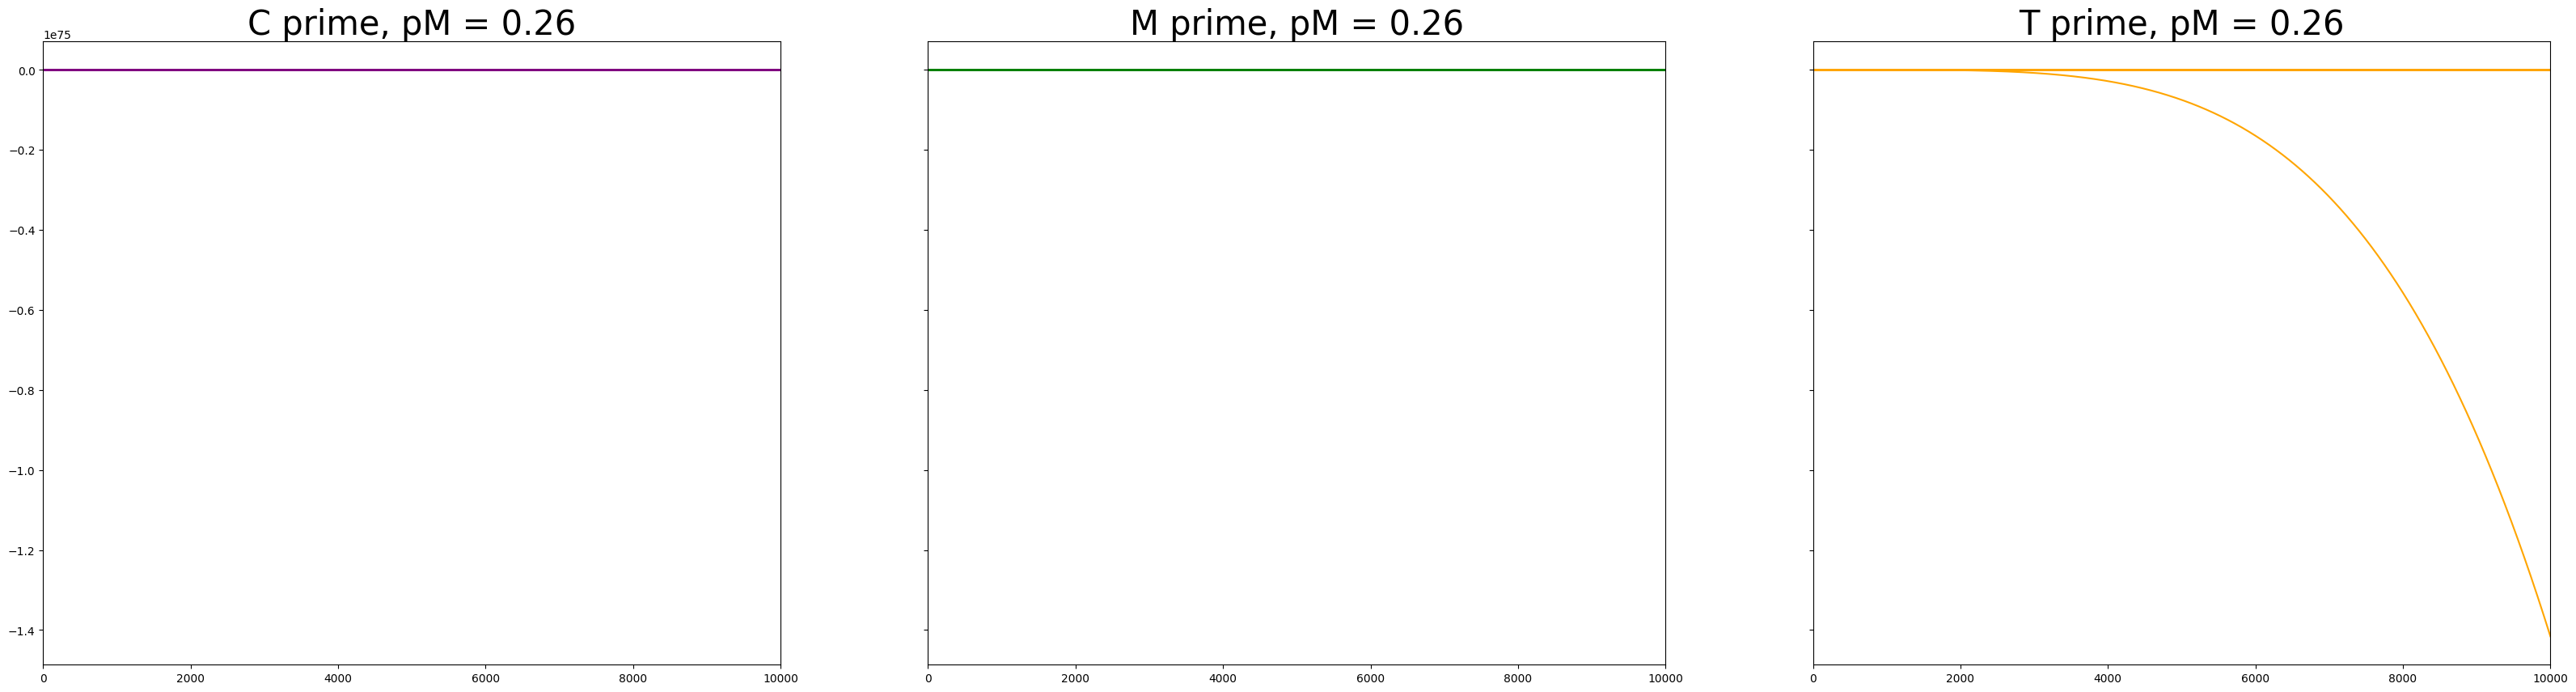

In [306]:
plottime(df_pM26, "pM = 0.26")

### pM = 0.38

In [307]:
start_time = time.perf_counter()

df_pM38 = PMEQ(0.38)

end_time = time.perf_counter()
(end_time - start_time)/60

7.793457788333763

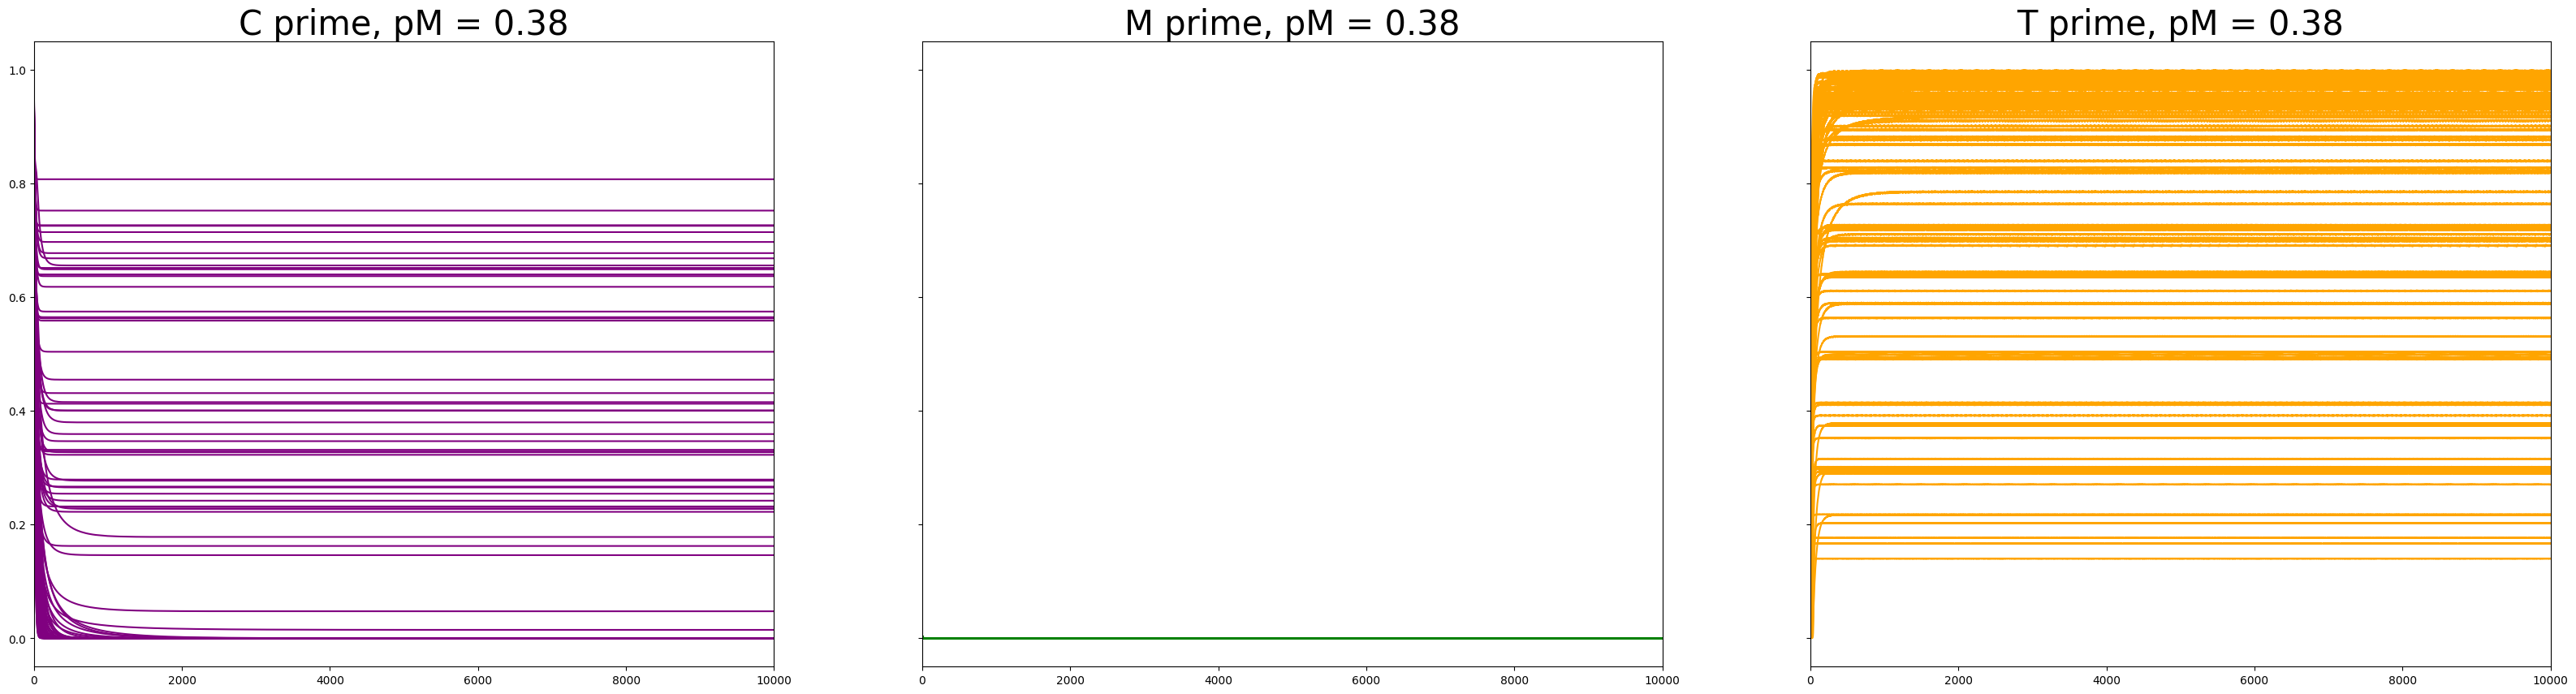

In [308]:
plottime(df_pM38, "pM = 0.38")

### pM = 0.50

In [309]:
start_time = time.perf_counter()

df_pM50 = PMEQ(0.50)

end_time = time.perf_counter()
(end_time - start_time)/60

6.836159415000778

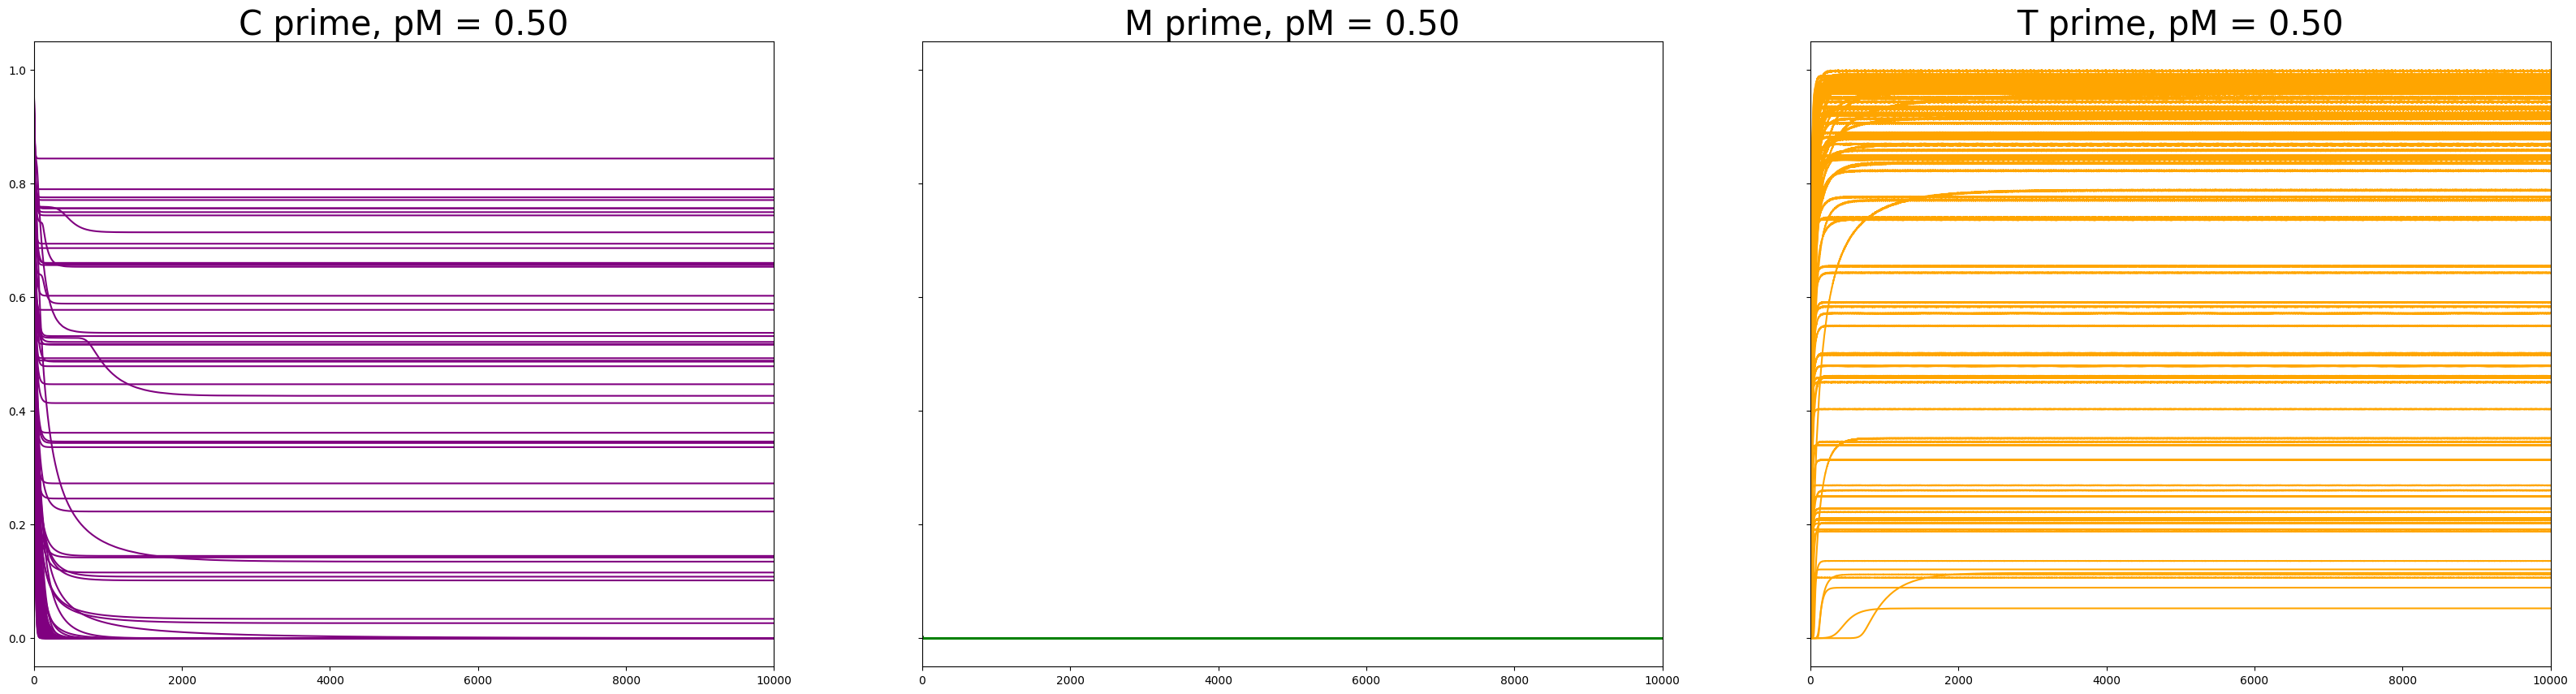

In [310]:
plottime(df_pM50, "pM = 0.50")

### pM = 0.62

In [311]:
start_time = time.perf_counter()

df_pM62 = PMEQ(0.62)

end_time = time.perf_counter()
(end_time - start_time)/60

8.25334905833394

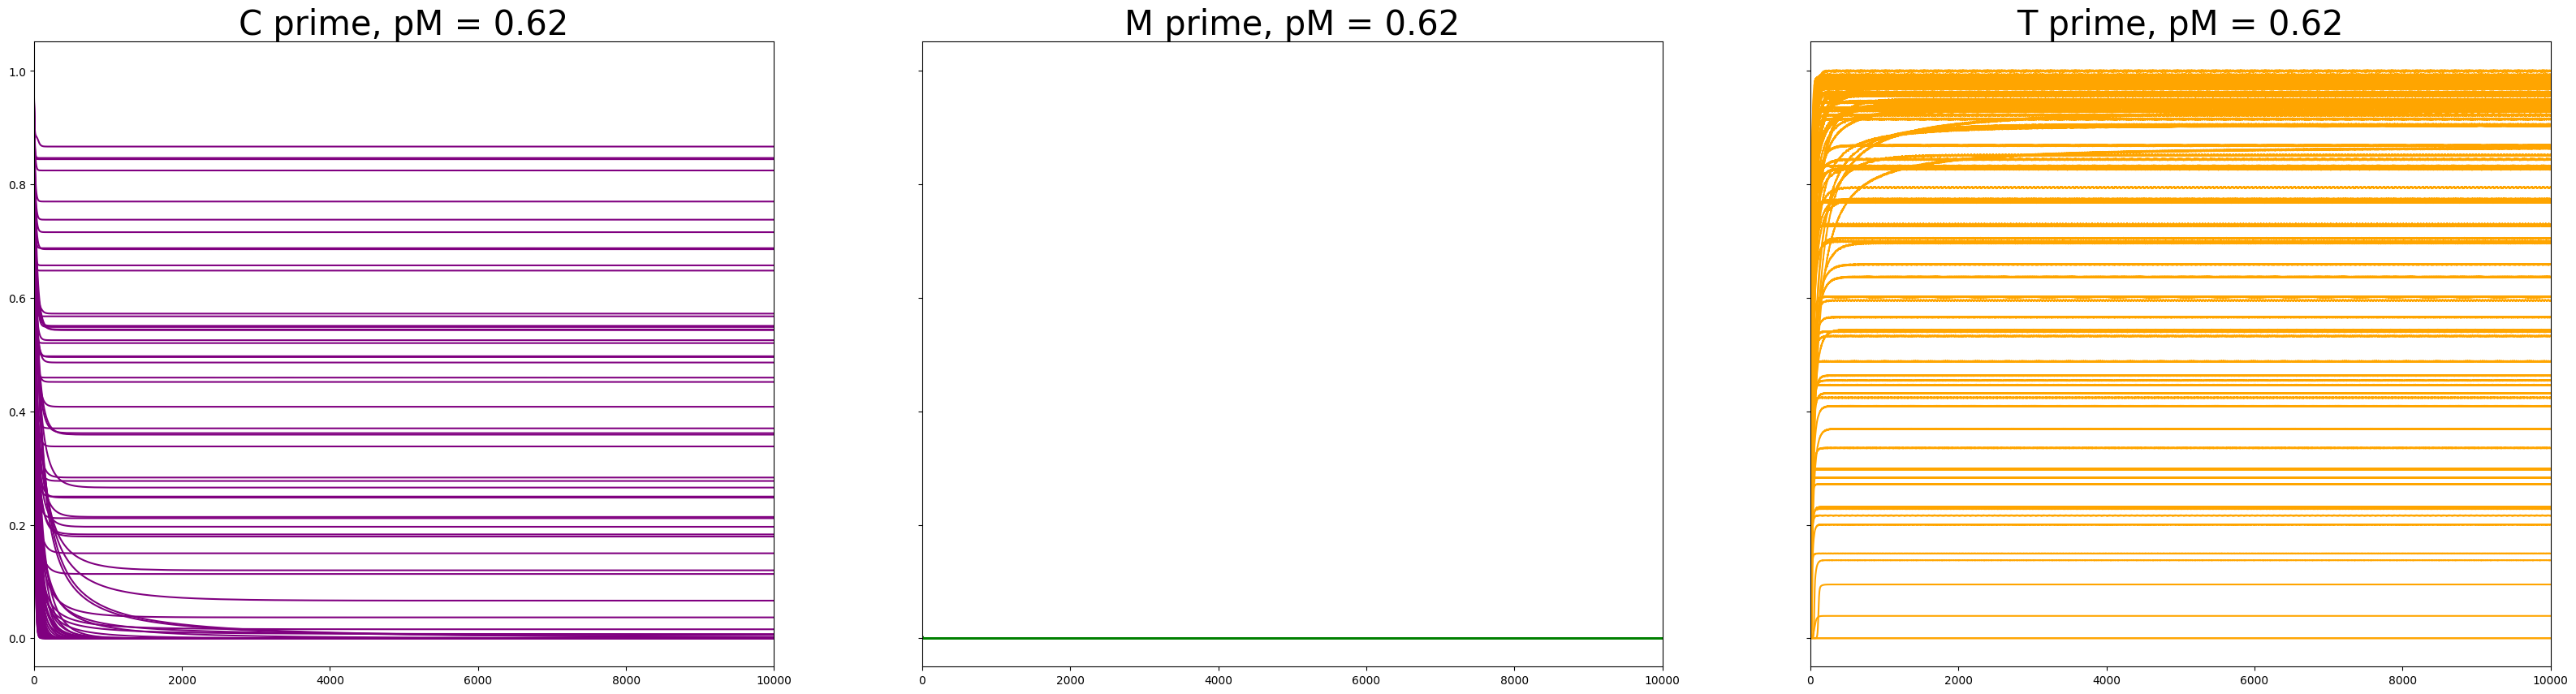

In [312]:
plottime(df_pM62, "pM = 0.62")

### pM = 0.74

In [313]:
start_time = time.perf_counter()

df_pM74 = PMEQ(0.74)

end_time = time.perf_counter()
(end_time - start_time)/60

8.082397976666106

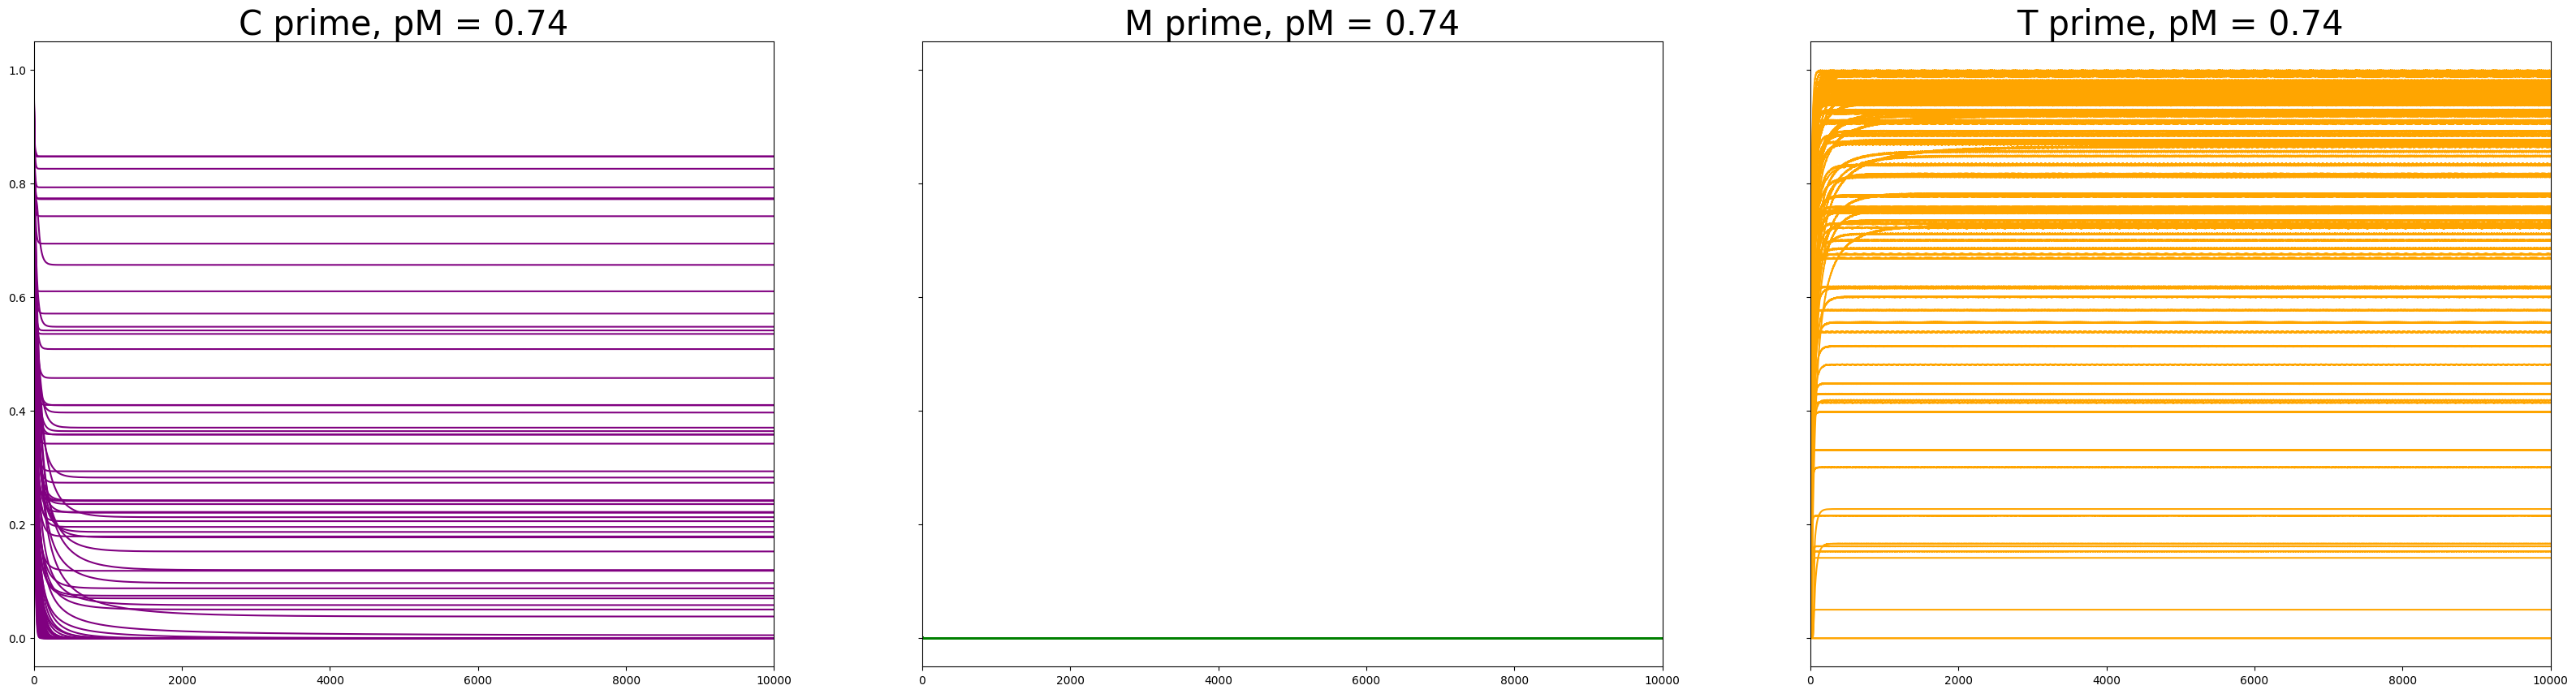

In [314]:
plottime(df_pM74, "pM = 0.74")

### pM = 0.86

In [315]:
start_time = time.perf_counter()

df_pM86 = PMEQ(0.86)

end_time = time.perf_counter()
(end_time - start_time)/60

7.6268409033335045

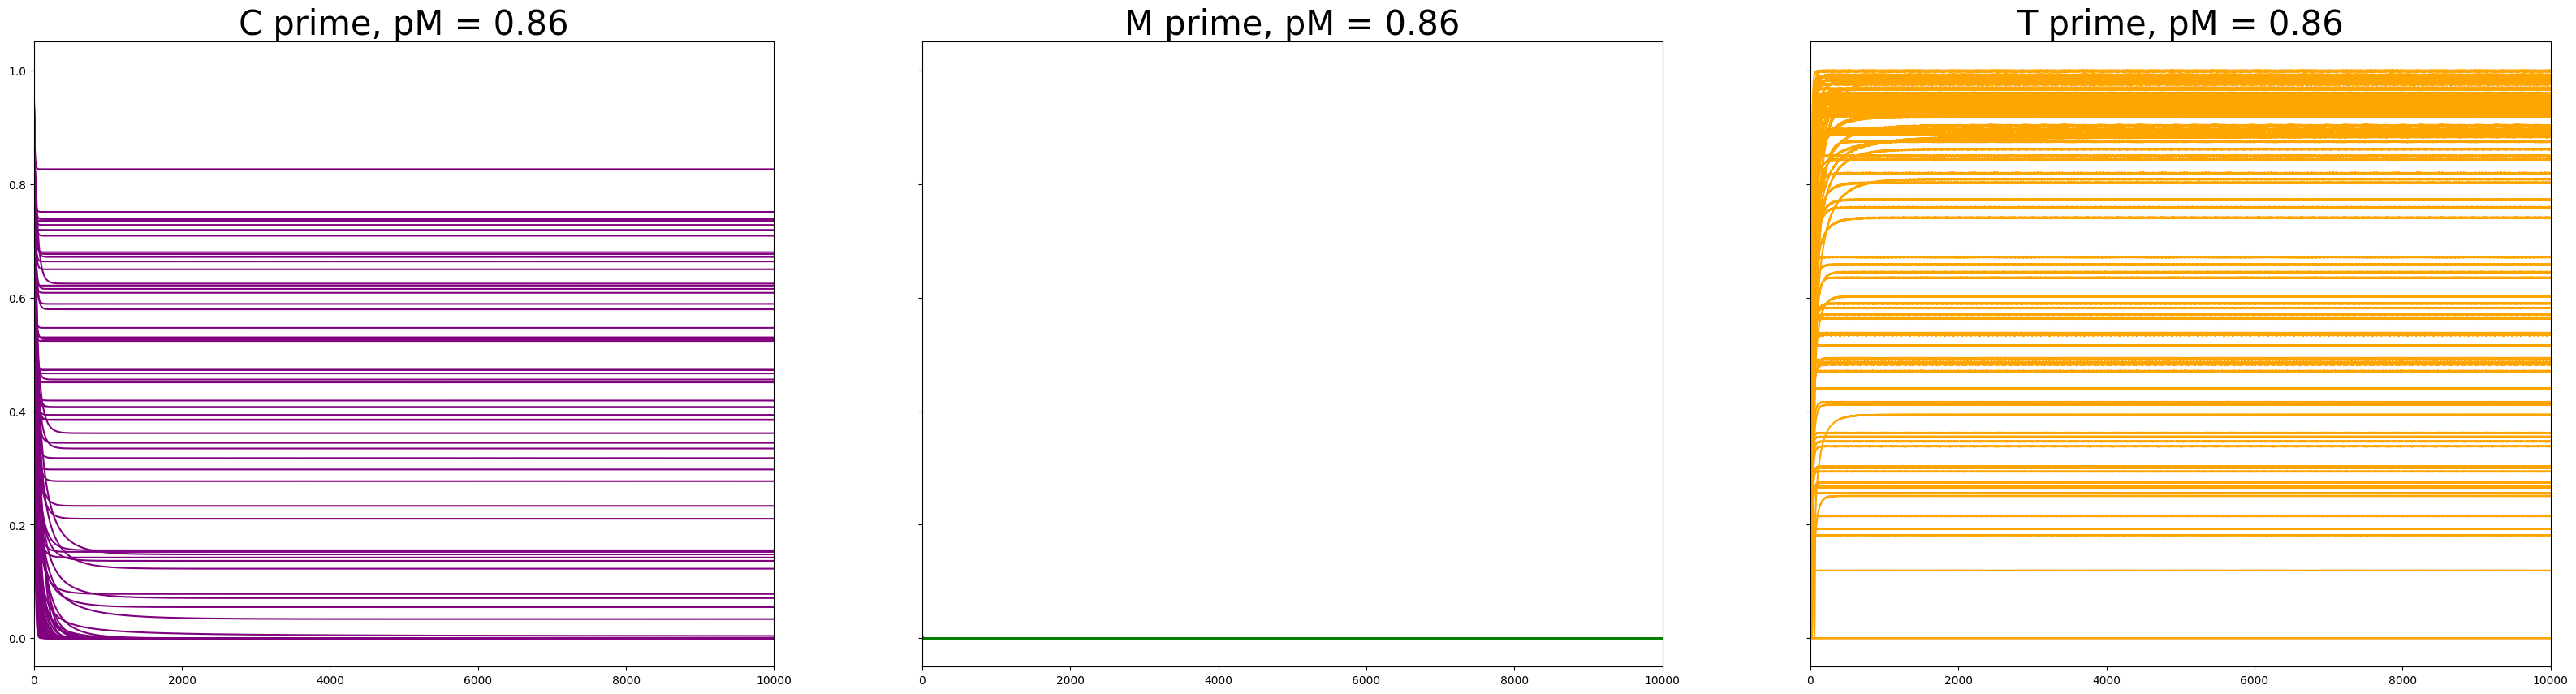

In [316]:
plottime(df_pM86, "pM = 0.86")

### pM = 0.98

In [317]:
start_time = time.perf_counter()

df_pM98 = PMEQ(0.98)

end_time = time.perf_counter()
(end_time - start_time)/60

6.582833103333057

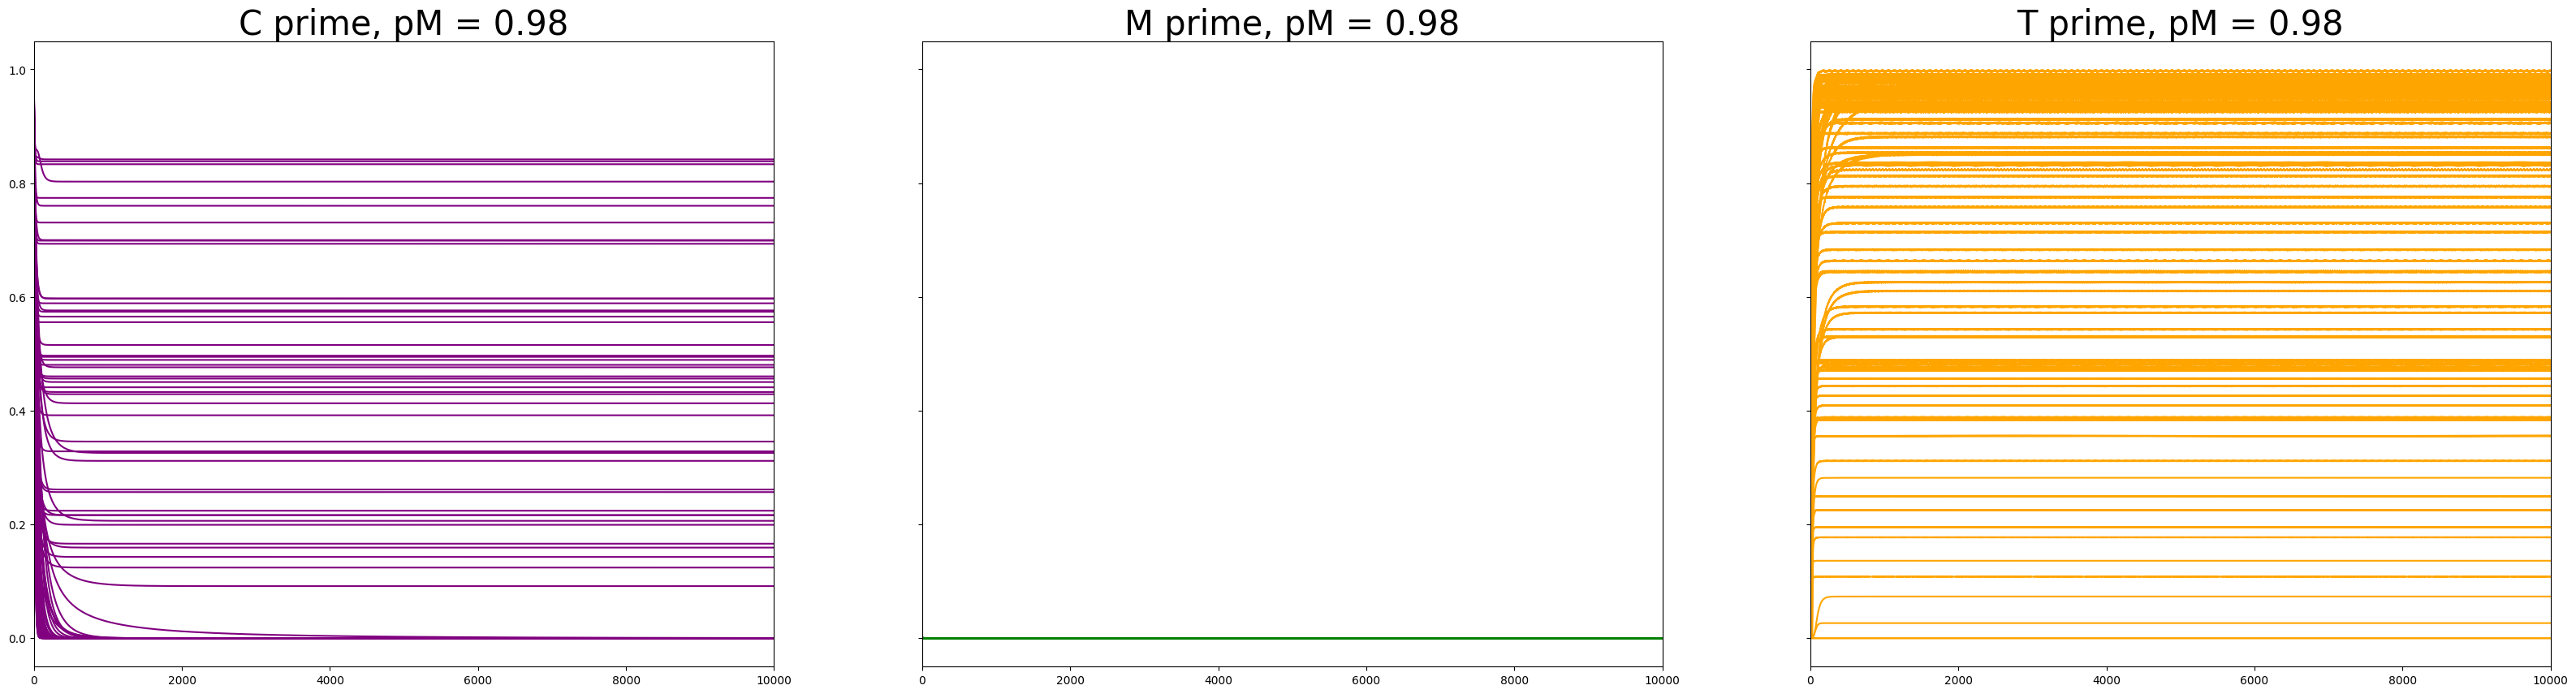

In [318]:
plottime(df_pM98, "pM = 0.98")

### pM = 1.1

In [319]:
start_time = time.perf_counter()

df_p110 = PMEQ(1.1)

end_time = time.perf_counter()
(end_time - start_time)/60

7.829795884999718

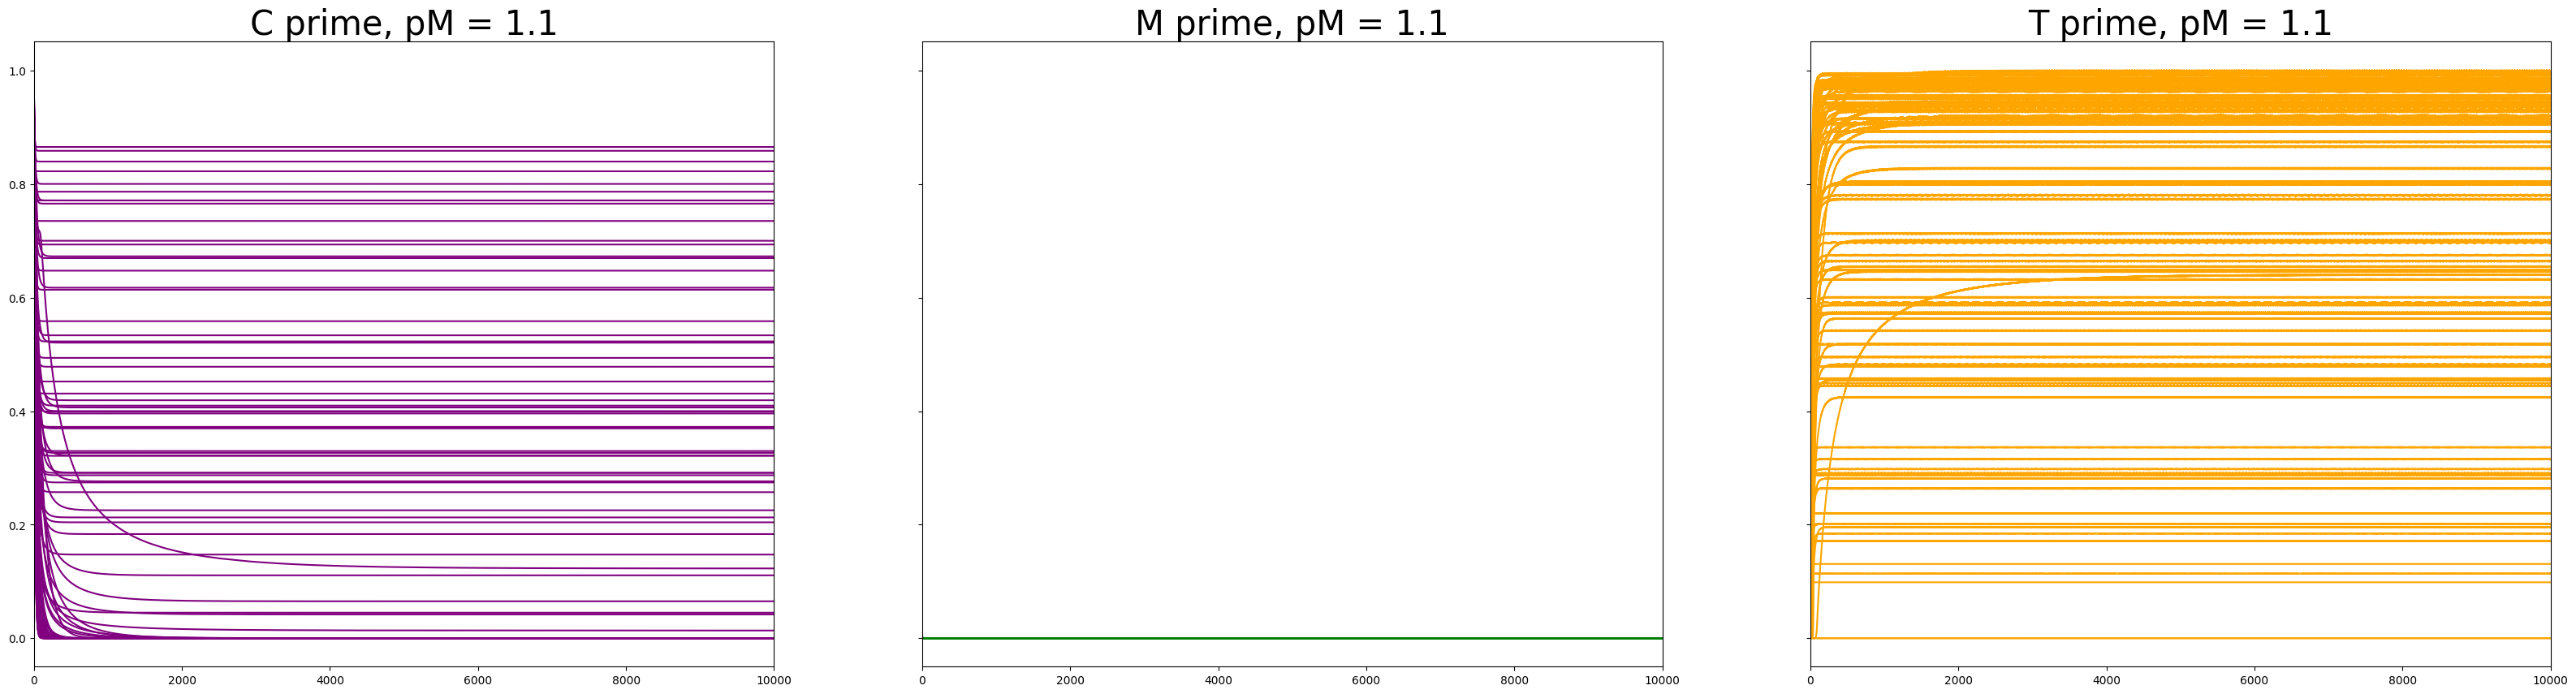

In [321]:
plottime(df_p110, "pM = 1.1")

# Defining function to find avg equilibrium benthic cover at each pM value

In [337]:
def avgfunc(pM, df):

    C_prime_avg = np.mean(df[1]['C_prime'])
    M_prime_avg = np.mean(df[1]['M_prime'])
    T_prime_avg = np.mean(df[1]['T_prime'])

    return([pM, C_prime_avg, M_prime_avg, T_prime_avg])

In [371]:
outputs = []

outputs.append(avgfunc(0.02, df_pM02))
outputs.append(avgfunc(0.14, df_pM14))
outputs.append(avgfunc(0.26, df_pM26))
outputs.append(avgfunc(0.38, df_pM38))
outputs.append(avgfunc(0.50, df_pM50))
outputs.append(avgfunc(0.62, df_pM62))
outputs.append(avgfunc(0.74, df_pM74))
outputs.append(avgfunc(0.86, df_pM86))
outputs.append(avgfunc(0.98, df_pM98))
outputs.append(avgfunc(1.1, df_p110))

avg_df = pd.DataFrame(outputs, columns=['pM', 'C_prime','M_prime','T_prime'])

# Plotting Benthic Cover at Equilibrium v. Macroalgae Mortality
### Note: when pM = 0.26, the system exploded. I was not sure how to handle it. I replotted after removing the equilibrium benthic cover values associated with pM = 0.26 to better visualize trends.

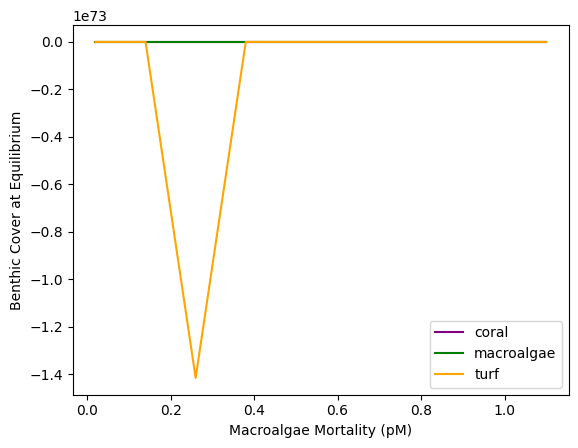

In [369]:
x = avg_df['pM']
C_prime = avg_df['C_prime']
M_prime = avg_df['M_prime']
T_prime = avg_df['T_prime']

plt.plot(x, C_prime, c = 'purple', label = 'coral')
plt.plot(x, M_prime, c = 'green', label = 'macroalgae')
plt.plot(x, T_prime, c = 'orange', label = 'turf')

plt.xlabel('Macroalgae Mortality (pM)')
plt.ylabel('Benthic Cover at Equilibrium')
plt.legend();

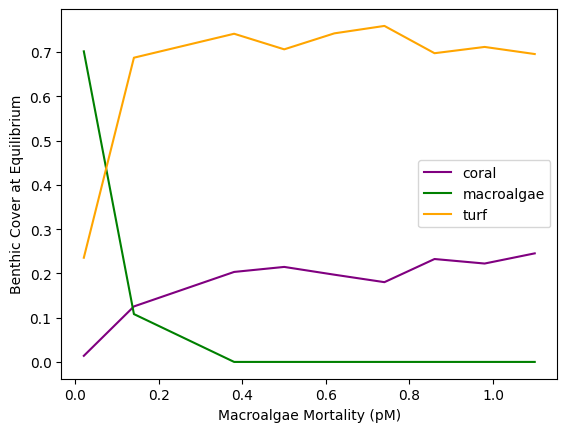

In [370]:
avg_df_no26 = avg_df[avg_df['pM'] != 0.26]

x = avg_df_no26['pM']
C_prime = avg_df_no26['C_prime']
M_prime = avg_df_no26['M_prime']
T_prime = avg_df_no26['T_prime']

plt.plot(x, C_prime, c = 'purple', label = 'coral')
plt.plot(x, M_prime, c = 'green', label = 'macroalgae')
plt.plot(x, T_prime, c = 'orange', label = 'turf')

plt.xlabel('Macroalgae Mortality (pM)')
plt.ylabel('Benthic Cover at Equilibrium')
plt.legend();